**Importamos las librerias necesarias**

In [1]:
from datasets import load_dataset
import openai
import os
from dotenv import load_dotenv
from openai import OpenAI
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import numpy as np
import re

c:\Users\gonzalo.arguedas\Project\TFG\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Cargamos los conjuntos de datos sobre los que vamos a trabajar

In [3]:
dataset = load_dataset('ai2_arc', 'ARC-Challenge')

AI2 Reasoning Challenge (ARC): Contiene preguntas de opción múltiple diseñadas para ser un desafío para los sistemas de IA, ya que requieren razonamiento complejo más allá de la simple recuperación de información.

In [3]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'choices', 'answerKey'],
        num_rows: 1119
    })
    test: Dataset({
        features: ['id', 'question', 'choices', 'answerKey'],
        num_rows: 1172
    })
    validation: Dataset({
        features: ['id', 'question', 'choices', 'answerKey'],
        num_rows: 299
    })
})


Accedemos a una muestra del dataset

In [4]:
sample = dataset['train'][0]
print("Pregunta:", sample['question'])
print("Opciones:", sample['choices']['text'])
print("Respuesta Correcta:", sample['choices']['text'][sample['choices']['label'].index(sample['answerKey'])])

Pregunta: George wants to warm his hands quickly by rubbing them. Which skin surface will produce the most heat?
Opciones: ['dry palms', 'wet palms', 'palms covered with oil', 'palms covered with lotion']
Respuesta Correcta: dry palms


In [5]:
dataset.shape

{'train': (1119, 4), 'test': (1172, 4), 'validation': (299, 4)}

Convertimos el dataset en un DataFrame de pandas para una exploracion mas facil

Cargamos la API Key para poder trabajar con los LLMs de OpenAI

In [2]:
load_dotenv()

api_key = os.getenv('OPENAI_API_KEY')
print("API Key cargada correctamente.")
client = OpenAI(api_key=api_key)

API Key cargada correctamente.


# **GPT-3.5-Turbo**

### Código Principal y Configuración del Dataset

En esta sección se carga el dataset `ai2_arc` y se seleccionan las primeras 100 muestras para evaluación. Este dataset se utilizará para probar las diferentes técnicas de ingeniería de enunciados y temperaturas en el modelo GPT-3.5 Turbo.

In [14]:
dataset_p = load_dataset('ai2_arc', 'ARC-Challenge')['train'].select(range(500))

La función `extraer_etiqueta_` se encarga de extraer la etiqueta de la respuesta generada por el modelo. La función utiliza una serie de patrones regex para encontrar y devolver la letra correspondiente a la opción correcta. Si no se encuentra un patrón coincidente, intenta extraer la primera letra mayúscula como último recurso.


In [15]:
def extraer_etiqueta_(respuesta):
    """Extrae la etiqueta de la respuesta generada por el modelo."""
    patterns = [
        r"^\s*(\w)\s*$",  
        r"^\s*(\w):",     
        r"^\s*(\w)\.",    
        r"^\s*(\w)\s"     
    ]
    for pattern in patterns:
        match = re.search(pattern, respuesta.strip(), re.IGNORECASE)
        if match:
            return match.group(1).upper()

    match = re.search(r"\b([A-Z])\b", respuesta)
    if match:
        return match.group(1).upper()
    
    return None  

La función `generar_respuesta_` envía un prompt al modelo GPT-3.5 Turbo, formado por la pregunta, opciones y la técnica de ingeniería de enunciados si se proporciona. Se implementa un manejo de errores con retries para asegurar la robustez en caso de fallos temporales de la API.


In [16]:
def generar_respuesta_(modelo, pregunta, opciones, tecnica=None, temperatura=0.5):
    opciones_texto = ', '.join([f"{chr(65+i)}: {opcion}" for i, opcion in enumerate(opciones)])
    if tecnica:
        prompt = f"{tecnica}\n\nPregunta: {pregunta}\nOpciones: {opciones_texto}\n¿Cuál es la respuesta correcta? (Responda con la letra correspondiente a la opción correcta)"
    else:
        prompt = f"Pregunta: {pregunta}\nOpciones: {opciones_texto}\n¿Cuál es la respuesta correcta? (Responda con la letra correspondiente a la opción correcta)"
    
    print(f"Prompt enviado al modelo: {prompt}")  # Debug: ver el prompt enviado
    
    completion = openai.chat.completions.create(
        model=modelo,
        messages=[{"role": "system", "content": prompt}, {"role": "user", "content": "What is the correct answer?"}],
        temperature=temperatura
    )
    
    respuesta_completa = completion.choices[0].message.content if completion.choices and completion.choices[0].message else "No response generated"
    print(f"Respuesta completa del modelo: {respuesta_completa}")  # Debug: ver respuesta completa del modelo
    
    respuesta = extraer_etiqueta_(respuesta_completa)
    print(f"Etiqueta extraída: {respuesta}")  # Debug: ver la etiqueta extraída
    return respuesta

La función `evaluar_temperaturas` evalúa la precisión del modelo GPT-3.5 Turbo para diferentes valores de temperatura. Para cada temperatura, se calcula la cantidad de respuestas correctas y se almacenan los resultados.


In [17]:
def evaluar_temperaturas(dataset, modelo, temperaturas):
    resultados_por_temp = {temp: [] for temp in temperaturas}
    for temp in temperaturas:
        correctas = 0
        for item in dataset:
            pregunta = item['question']
            opciones = item['choices']['text']
            respuesta_correcta = item['answerKey']
            respuesta_generada = generar_respuesta_(modelo, pregunta, opciones, temperatura=temp)
            es_correcta = respuesta_generada == respuesta_correcta if respuesta_generada else False
            resultados_por_temp[temp].append(es_correcta)
            if es_correcta:
                correctas += 1
        print(f"Temperatura {temp}: {correctas} respuestas correctas de {len(dataset)}")
    return resultados_por_temp

Se indican las temperaturas en las que el modelo responda las respuestas correctas, con el fin de averiguar cuanto de creativo debemos ajustar el modelo para responder correctamente a las cuestiones

In [18]:
temperaturas = [1, 0]
resultados = evaluar_temperaturas(dataset_p, "gpt-3.5-turbo", temperaturas)

Prompt enviado al modelo: Pregunta: George wants to warm his hands quickly by rubbing them. Which skin surface will produce the most heat?
Opciones: A: dry palms, B: wet palms, C: palms covered with oil, D: palms covered with lotion
¿Cuál es la respuesta correcta? (Responda con la letra correspondiente a la opción correcta)
Respuesta completa del modelo: C: palms covered with oil
Etiqueta extraída: C
Prompt enviado al modelo: Pregunta: Which of the following statements best explains why magnets usually stick to a refrigerator door?
Opciones: A: The refrigerator door is smooth., B: The refrigerator door contains iron., C: The refrigerator door is a good conductor., D: The refrigerator door has electric wires in it.
¿Cuál es la respuesta correcta? (Responda con la letra correspondiente a la opción correcta)
Respuesta completa del modelo: B: The refrigerator door contains iron.
Etiqueta extraída: B
Prompt enviado al modelo: Pregunta: A fold observed in layers of sedimentary rock most like

In [19]:
precisiones = {temp: np.mean(resultados[temp]) * 100 for temp in temperaturas}
print(precisiones)

{1: 81.39999999999999, 0: 82.19999999999999}


Graficamos los resultados obtenidos para las temperaturas propuestas

C:\Users\gonzalo.arguedas\AppData\Local\Temp\ipykernel_1600\3053475110.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("viridis")  # Puedes cambiar 'viridis' por cualquier otro mapa de colores disponible


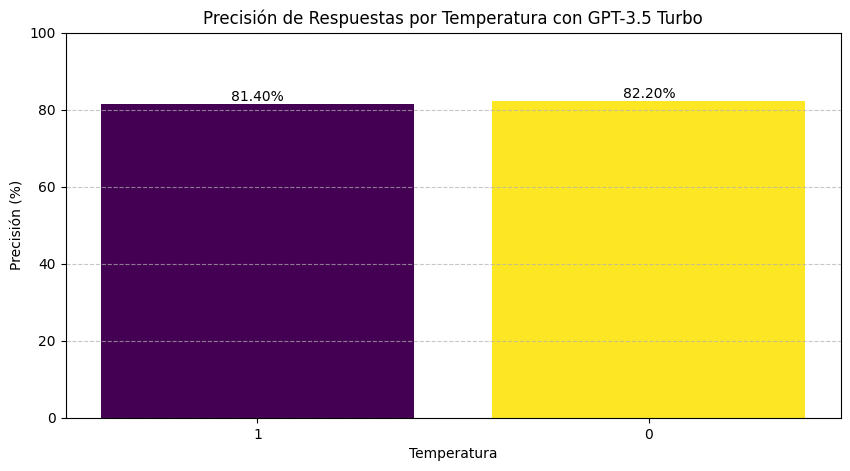

In [20]:
cmap = get_cmap("viridis")  # Puedes cambiar 'viridis' por cualquier otro mapa de colores disponible

# Convertir las claves del diccionario a string para mejorar la visualización en el eje x
temperaturas_str = [str(temp) for temp in precisiones.keys()]
precision_values = list(precisiones.values())

# Generar una lista de colores del mapa de colores
colors = cmap(np.linspace(0, 1, len(precisiones)))

# Graficar los resultados
plt.figure(figsize=(10, 5))
bars = plt.bar(temperaturas_str, precision_values, color=colors)
plt.xlabel('Temperatura')
plt.ylabel('Precisión (%)')
plt.title('Precisión de Respuestas por Temperatura con GPT-3.5 Turbo')
plt.ylim([0, 100])  # Asegurando que el eje y va de 0 a 100%
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir etiquetas de texto para cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}%", ha='center', va='bottom')

plt.show()

Técnicas a aplicar

In [68]:
tecnicas = {
    "Think step by step.": "CoT",  # Chain of Thought
    "Provide multiple reasoned answers and select the best one.": "CoT-SC",  # CoT with Self-Consistency
    "Imagine different experts providing step-by-step thoughts.": "ToT",  # Tree of Thoughts
    "Provide detailed context and check sources.": "TCP",  # Tagged Context Prompts
    "Consider your answer carefully and check it before finalizing.": "Auto",  # Autocorrection
    "Combine insights from multiple viewpoints to find the correct answer.": "MA"  # Multiple Agents
}

La función `evaluar_tecnicas` evalúa la precisión del modelo GPT-3.5 Turbo utilizando diferentes técnicas de ingeniería de enunciados. Para cada técnica, se genera una respuesta y se compara con la respuesta correcta.


In [59]:
def evaluar_tecnicas(dataset, modelo, tecnicas, temperatura=0.5):
    resultados_por_tecnica = {name: [] for name in tecnicas.values()}
    for item in dataset:
        pregunta = item['question']
        opciones = item['choices']['text']
        respuesta_correcta = item['answerKey']
        for tecnica, name in tecnicas.items():
            respuesta_generada = generar_respuesta_(modelo, pregunta, opciones, tecnica, temperatura=temperatura)
            es_correcta = respuesta_generada == respuesta_correcta if respuesta_generada else False
            resultados_por_tecnica[name].append(es_correcta)
            print(f"Técnica {name}, temperatura {temperatura}: Respuesta generada: {respuesta_generada}, Correcta: {es_correcta}")
    return resultados_por_tecnica


# Evaluar las técnicas a una temperatura fija
temperatura = 0.5
resultados_tecnicas = evaluar_tecnicas(dataset_p, "gpt-3.5-turbo", tecnicas, temperatura)

Prompt enviado al modelo: Think step by step.

Pregunta: George wants to warm his hands quickly by rubbing them. Which skin surface will produce the most heat?
Opciones: A: dry palms, B: wet palms, C: palms covered with oil, D: palms covered with lotion
¿Cuál es la respuesta correcta? (Responda con la letra correspondiente a la opción correcta)
Respuesta completa del modelo: B: wet palms
Etiqueta extraída: B
Técnica CoT, temperatura 0.5: Respuesta generada: B, Correcta: False
Prompt enviado al modelo: Provide multiple reasoned answers and select the best one.

Pregunta: George wants to warm his hands quickly by rubbing them. Which skin surface will produce the most heat?
Opciones: A: dry palms, B: wet palms, C: palms covered with oil, D: palms covered with lotion
¿Cuál es la respuesta correcta? (Responda con la letra correspondiente a la opción correcta)
Respuesta completa del modelo: The correct answer is B: wet palms. When rubbing wet palms together, the friction generated will produ

La siguiente sección crea un gráfico de barras para visualizar la precisión del modelo utilizando diferentes técnicas de ingeniería de enunciados. Al igual que en el gráfico de temperatura, se utiliza el mapa de colores `viridis`.


{'CoT': 83.0, 'CoT-SC': 84.0, 'ToT': 78.0, 'TCP': 86.0, 'Auto': 85.0, 'MA': 82.0}


C:\Users\gonzalo.arguedas\AppData\Local\Temp\ipykernel_17756\1182638157.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("viridis")


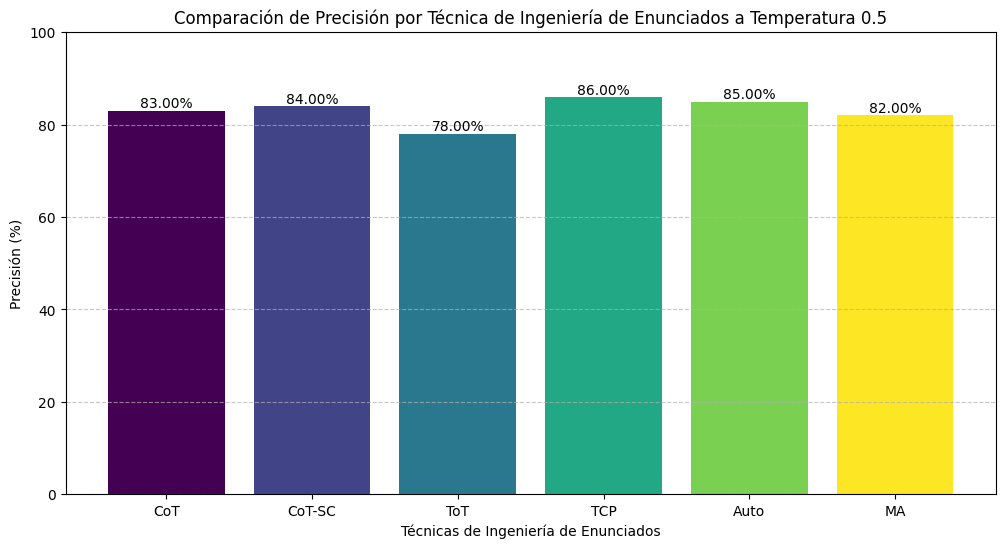

In [60]:
precisiones = {name: np.mean(resultados) * 100 for name, resultados in resultados_tecnicas.items()}
print(precisiones)

# Graficar los resultados
cmap = get_cmap("viridis")  

# Convertir las claves del diccionario a string para mejorar la visualización en el eje x
tecnicas_str = list(precisiones.keys())
precision_values = list(precisiones.values())

colors = cmap(np.linspace(0, 1, len(precisiones)))

plt.figure(figsize=(12, 6))
bars = plt.bar(tecnicas_str, precision_values, color=colors)
plt.xlabel('Técnicas de Ingeniería de Enunciados')
plt.ylabel('Precisión (%)')
plt.title('Comparación de Precisión por Técnica de Ingeniería de Enunciados a Temperatura 0.5')
plt.ylim([0, 100])  # Asegurando que el eje y va de 0 a 100%
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir etiquetas de texto para cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}%", ha='center', va='bottom')

plt.show()

### **GPT-4-TURBO**

In [3]:
dataset = load_dataset('openbookqa', 'additional')['train'].select(range(100))

In [10]:
def extraer_etiqueta_(respuesta):
    """Extrae la etiqueta de la respuesta generada por el modelo."""
    patterns = [
        r"THE CORRECT ANSWER IS (\w):",
        r"^\s*(\w)\.",
        r"^\s*(\w)\s",
        r"RESPUESTA CORRECTA: (\w)",  
    ]
    for pattern in patterns:
        match = re.search(pattern, respuesta, re.IGNORECASE)
        if match:
            return match.group(1).upper()
    return None  # Devolver None si no encuentra una respuesta válida

In [11]:
def generar_respuesta_(modelo, pregunta, opciones, temperatura=0.5, intentos=3):
    """Genera respuestas utilizando un modelo de OpenAI con una temperatura específica, reintentando si es necesario."""
    opciones_texto = ', '.join([f"{chr(65+i)}: {opcion}" for i, opcion in enumerate(opciones)])
    prompt = f"Pregunta: {pregunta}\nOpciones: {opciones_texto}\n¿Cuál es la respuesta correcta? (Responda con la letra correspondiente a la opción correcta)"
    respuesta = None
    while intentos > 0 and respuesta is None:
        messages = [{"role": "system", "content": prompt}, {"role": "user", "content": "What is the correct answer?"}]
        completion = client.chat.completions.create(
            model=modelo,
            messages=messages,
            temperature=temperatura
        )
        respuesta_completa = completion.choices[0].message.content if completion.choices and completion.choices[0].message else "No response generated"
        respuesta = extraer_etiqueta_(respuesta_completa)
        intentos -= 1
    print(f"Respuesta generada para temperatura {temperatura}: {respuesta or 'No valid response found'}")
    return respuesta

In [6]:
def evaluar_temperaturas_(dataset, modelo, temperaturas):
    resultados_por_temp = {temp: [] for temp in temperaturas}
    for temp in temperaturas:
        correctas = 0
        for item in dataset:
            pregunta = item['question_stem']
            opciones = item['choices']['text']
            respuesta_correcta = item['answerKey']
            respuesta_generada = generar_respuesta_(modelo, pregunta, opciones, temperatura=temp)
            es_correcta = respuesta_generada == respuesta_correcta if respuesta_generada else False
            resultados_por_temp[temp].append(es_correcta)
            if es_correcta:
                correctas += 1
        print(f"Temperatura {temp}: {correctas} respuestas correctas de {len(dataset)}")
    return resultados_por_temp

In [8]:
temperaturas = [1, 0.7, 0.5, 0.3, 0]
resultados = evaluar_temperaturas_(dataset, "gpt-4-turbo", temperaturas)

Respuesta generada para temperatura 1: D
Respuesta generada para temperatura 1: D
Respuesta generada para temperatura 1: C
Respuesta generada para temperatura 1: C
Respuesta generada para temperatura 1: D
Respuesta generada para temperatura 1: A
Respuesta generada para temperatura 1: D
Respuesta generada para temperatura 1: D
Respuesta generada para temperatura 1: A
Respuesta generada para temperatura 1: D
Respuesta generada para temperatura 1: A
Respuesta generada para temperatura 1: C
Respuesta generada para temperatura 1: C
Respuesta generada para temperatura 1: B
Respuesta generada para temperatura 1: B
Respuesta generada para temperatura 1: A
Respuesta generada para temperatura 1: B
Respuesta generada para temperatura 1: No valid response found
Respuesta generada para temperatura 1: C
Respuesta generada para temperatura 1: A
Respuesta generada para temperatura 1: B
Respuesta generada para temperatura 1: D
Respuesta generada para temperatura 1: A
Respuesta generada para temperatura

In [9]:
precisiones = {temp: np.mean(resultados[temp]) * 100 for temp in temperaturas}
precisiones

{1: 88.0, 0.7: 91.0, 0.5: 93.0, 0.3: 92.0, 0: 91.0}

C:\Users\gonzalo.arguedas\AppData\Local\Temp\ipykernel_16916\1119117750.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("viridis")  # Puedes cambiar 'viridis' por cualquier otro mapa de colores disponible


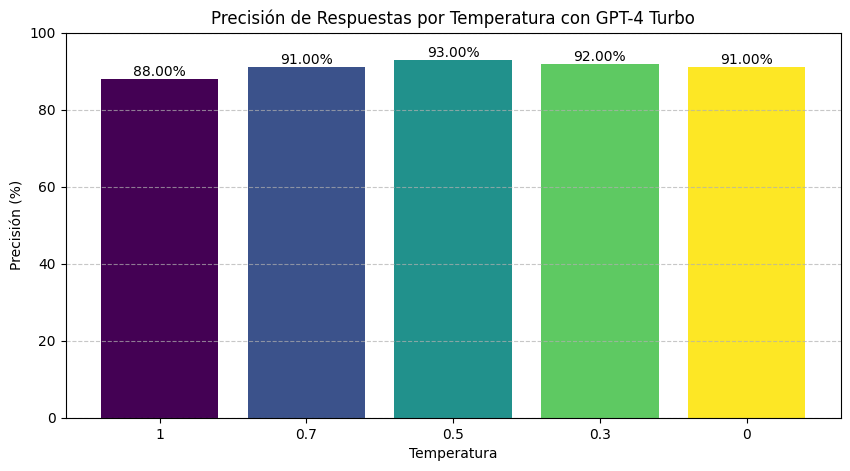

In [10]:
cmap = get_cmap("viridis")  # Puedes cambiar 'viridis' por cualquier otro mapa de colores disponible

# Convertir las claves del diccionario a string para mejorar la visualización en el eje x
temperaturas_str = [str(temp) for temp in precisiones.keys()]
precision_values = list(precisiones.values())

# Generar una lista de colores del mapa de colores
colors = cmap(np.linspace(0, 1, len(precisiones)))

# Graficar los resultados
plt.figure(figsize=(10, 5))
bars = plt.bar(temperaturas_str, precision_values, color=colors)
plt.xlabel('Temperatura')
plt.ylabel('Precisión (%)')
plt.title('Precisión de Respuestas por Temperatura con GPT-4 Turbo')
plt.ylim([0, 100])  # Asegurando que el eje y va de 0 a 100%
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir etiquetas de texto para cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}%", ha='center', va='bottom')

plt.show()

Observamos que las mejores precisiones se obtienen en temperaturas intermedias, es decir, ni muy altas ni muy bajas, de todas formas, todos los resultados son resultados bastante precisos

In [23]:
tecnicas = {
    None: "Std",  # Standard, sin técnica
    "Think step by step.": "CoT",  # Chain of Thought
    "Provide multiple reasoned answers and select the best one.": "CoT-SC",  # CoT with Self-Consistency
    "Imagine different experts providing step-by-step thoughts.": "ToT",  # Tree of Thoughts
    "Provide detailed context and check sources.": "TCP",  # Tagged Context Prompts
    "Consider your answer carefully and check it before finalizing.": "Auto",  # Autocorrection
    "Combine insights from multiple viewpoints to find the correct answer.": "MA"  # Multiple Agents
}

In [8]:
def generar_respuesta_(modelo, pregunta, opciones, tecnica=None, temperatura=0.5):
    opciones_texto = ', '.join([f"{chr(65+i)}: {opcion}" for i, opcion in enumerate(opciones)])
    if tecnica:
        prompt = f"{tecnica}\n\nPregunta: {pregunta}\nOpciones: {opciones_texto}\n¿Cuál es la respuesta correcta? (Responda con la letra correspondiente a la opción correcta)"
    else:
        prompt = f"Pregunta: {pregunta}\nOpciones: {opciones_texto}\n¿Cuál es la respuesta correcta? (Responda con la letra correspondiente a la opción correcta)"
    
    print(f"Prompt enviado al modelo: {prompt}")  # Debug: ver el prompt enviado
    
    completion = client.chat.completions.create(
        model=modelo,
        messages=[{"role": "system", "content": prompt}, {"role": "user", "content": "What is the correct answer?"}],
        temperature=temperatura
    )
    
    respuesta_completa = completion.choices[0].message.content if completion.choices and completion.choices[0].message else "No response generated"
    print(f"Respuesta completa del modelo: {respuesta_completa}")  # Debug: ver respuesta completa del modelo
    
    respuesta = extraer_etiqueta_(respuesta_completa)
    print(f"Etiqueta extraída: {respuesta}")  # Debug: ver la etiqueta extraída
    return respuesta

In [ ]:
def letra_a_indice(letra):
    """Convierte una letra de respuesta ('A', 'B', 'C', 'D') a un índice numérico (0, 1, 2, 3)."""
    return ord(letra) - ord('A')  # 'A' se convierte en 0, 'B' en 1, etc.

def evaluar_tecnicas_(dataset, modelo, tecnicas, temperatura=0.5):
    resultados_por_tecnica = {name: [] for name in tecnicas.values()}
    for item in dataset:
        pregunta = item['question_stem']
        opciones = item['choices']['text']
        indice_correcto = letra_a_indice(item['answerKey'])  # Usa la función para convertir la letra a índice
        respuesta_correcta = opciones[indice_correcto]       # Usa el índice para obtener la opción correcta
        for tecnica, name in tecnicas.items():
            respuesta_generada = generar_respuesta_(modelo, pregunta, opciones, tecnica, temperatura)
            es_correcta = respuesta_generada == item['answerKey'] if respuesta_generada else False
            resultados_por_tecnica[name].append(es_correcta)
            print(f"Técnica {name}, temperatura {temperatura}: Respuesta generada: {respuesta_generada}, Correcta: {es_correcta}")
    return resultados_por_tecnica

resultados_tecnicas = evaluar_tecnicas_(dataset, "gpt-4-turbo", tecnicas, 0.5)

C:\Users\gonzalo.arguedas\AppData\Local\Temp\ipykernel_17248\154518386.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('plasma')  # 'tab10' proporciona 10 colores distintos


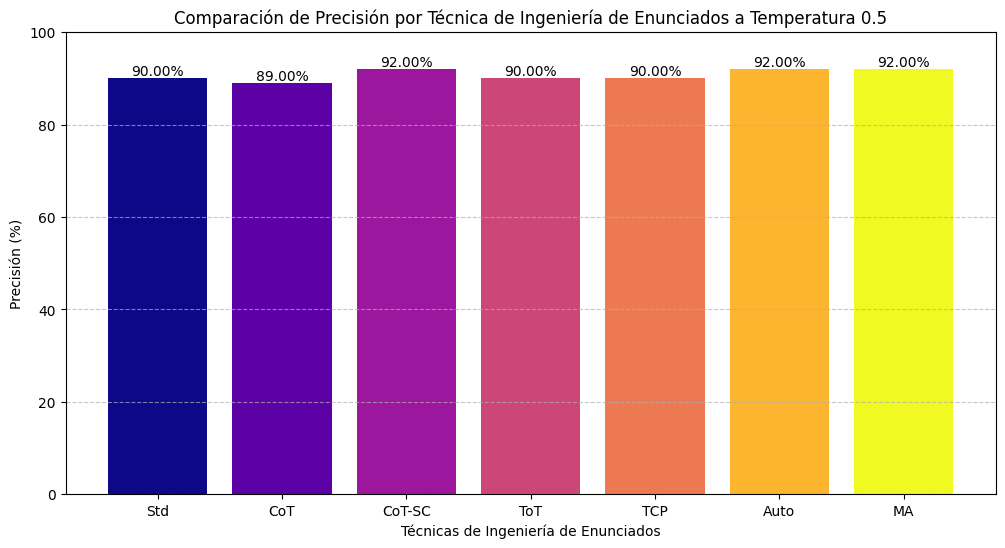

In [14]:
precisiones_por_tecnica = {name: np.mean(resultados) * 100 for name, resultados in resultados_tecnicas.items()}

cmap = get_cmap('plasma')  # 'tab10' proporciona 10 colores distintos
colors = cmap(np.linspace(0, 1, len(precisiones_por_tecnica)))

tecnicas_str = list(precisiones_por_tecnica.keys())
precision_values = list(precisiones_por_tecnica.values())

# Graficar los resultados
plt.figure(figsize=(12, 6))
bars = plt.bar(tecnicas_str, precision_values, color=colors)
plt.xlabel('Técnicas de Ingeniería de Enunciados')
plt.ylabel('Precisión (%)')
plt.title('Comparación de Precisión por Técnica de Ingeniería de Enunciados a Temperatura 0.5')
plt.ylim([0, 100])  # Asegurando que el eje y va de 0 a 100%
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir etiquetas de texto para cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}%", ha='center', va='bottom')

plt.show()